In [1]:
import argparse
import csv
import re
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import utils

from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes

def parse_trace(trace_file_name: str) -> pl.DataFrame:
    """
    # parse_trace

    Parse a trace file and return a polars DataFrame.

        Parameters:
            trace_file_name (str): The name of the trace file.

        Returns:
            polars.DataFrame: The parsed trace.

    Format of the trace file:
        (line number as index) gap ddl size prio

        Example:
            ```
            0.1 200 1300 1
            0.1 200 1300 2
    """
    trace = []
    with open(trace_file_name, "r") as f:
        lines = f.readlines()
        for idx, line in enumerate(lines):
            info = re.split(r"\s+", line)
            trace.append(
                {
                    "id": idx,
                    "start": float(info[0]),
                    "gap": float(info[0]),
                    "ddl": int(info[1]),
                    "size": int(info[2]),
                    "prio": int(info[3]),
                }
            )
    trace = pl.from_dicts(trace)
    trace["start"] = trace["start"].cumsum()
    return trace

def parse_server_log(server_log_file_name: str) -> pl.DataFrame:
    """
    # parse_server_log

    Parse a server log file and return a polars DataFrame.

        Parameters:
            server_log_file_name (str): The name of the server log file.

        Returns:
            polars.DataFrame: The parsed server log.

    Format of the server log file:
        CSV file with following columns:
        - block_id
        - start
        - complete
        - cancelled
        - cancelled_passed
    """
    try:
        server_log = pl.read_csv(server_log_file_name)
        server_log["block_id"] = server_log["block_id"].apply(lambda x: (x >> 2) - 1)
        return server_log
    except:
        return pl.DataFrame(
            None, ["block_id", "start", "complete", "cancelled", "cancelled_passed"]
        )

def parse_result(result_file_name: str) -> pl.DataFrame:
    """
    # parse_result

    Parse a result file and return a polars DataFrame.

        Parameters:
            result_file_name (str): The name of the result file.

        Returns:
            polars.DataFrame: The parsed result.

    Format of the result file:
        CSV file with following columns:
        - block_id
        - bct
        - size
        - priority
        - deadline
        - duration
    """
    try:
        result = pl.read_csv(result_file_name)
        result["block_id"] = result["block_id"].apply(lambda x: (x >> 2) - 1)
        return result
    except:
        return pl.DataFrame(
            None, ["block_id", "bct", "size", "priority", "deadline", "duration"]
        )
        
def find_unsend(result_file_name, trace_file_name):
    if trace_file_name is not None:
        block_num = utils.count_newlines(trace_file_name)
        trace = set(range(block_num))

        with open(result_file_name, "r") as f:
            reader = csv.DictReader(f)
            result = [((int(row["block_id"]) - 1) >> 2) - 1 for row in reader]

        res = sorted([(x, ((x + 1) << 2) + 1) for x in trace - set(result)])

        return (len(res), res)
    else:
        raise Exception("trace_file_name is None")


def total_time(trace_file_name):
    with open(trace_file_name, "r") as f:
        reader = csv.reader(f, delimiter=" ")
        return sum([float(row[0]) for row in reader])


def draw(result_file_name, trace_file_name):
    result = pl.read_csv(result_file_name)
    result["block_id"] = result["block_id"].apply(lambda x: (x >> 2) - 1)
    trace = parse_trace(trace_file_name).rename({"gap": "start"})
    trace["start"] = trace["start"].cumsum()
    result = result.join(trace, left_on="block_id", right_on="id", how="outer")
    print(result)
    result = result.select(
        [
            "block_id",
            (pl.col("bct") / 1000 < pl.col("ddl")).alias("intime"),
            # (
            #     (pl.col("duration") / 1000) < (pl.col("ddl") + pl.col("start") * 1000)
            # ).alias("intime"),
            "prio",
            "ddl",
            (pl.col("ddl") / 1e3 + pl.col("start")).alias("timestamp"),
        ]
    )
    print(result)

    x = result["timestamp"].to_numpy()
    y = np.zeros((8, len(x)))
    y_count = np.zeros(8)
    y_intime = np.zeros(8)
    for i in range(len(x)):
        y_count[result["prio"][i]] += 1
        if result["intime"][i]:
            y_intime[result["prio"][i]] += 1
        for j in range(8):
            y[j][i] = y_intime[j] / y_count[j] if y_count[j] > 0 else 1

    fig, ax = plt.subplots()
    # ax.plot(x, y[0], label="prio 0")
    ax.plot(x, y[1], label="prio 1")
    ax.plot(x, y[2], label="prio 2")
    # ax.plot(x, y[3], label="prio 3")
    # ax.plot(x, y[4], label="prio 4")
    # ax.plot(x, y[5], label="prio 5")
    # ax.plot(x, y[6], label="prio 6")
    # ax.plot(x, y[7], label="prio 7")

    ax.set_ylim(0, 1.05)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("average intime ratio")
    ax.legend()

    plt.savefig(f"{os.path.basename(result_file_name).split('.')[0]}.png")

    result = result.groupby("prio").agg([pl.count(), (pl.col("intime") == True).sum()])
    print(result)

def hist(result_file_name, trace_file_name):
    trace = parse_trace(trace_file_name)
    # print(
    #     trace.groupby("prio").agg(
    #         [
    #             pl.count(),
    #             pl.mean("size").alias("size_mean"),
    #             pl.var("size").alias("size_var"),
    #         ]
    #     )
    # )
    # trace = trace.partition_by("prio")
    # prio_1 = trace[0]["size"].to_numpy()
    # prio_2 = trace[1]["size"].to_numpy()

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")
    # trace = trace["size"].to_numpy()
    # fig, ax = plt.subplots()
    # # ax.plot(trace)
    # ax.scatter(np.arange(len(trace)), trace)
    # plt.savefig("trace_size.png")

    # result = pl.read_csv(result_file_name)
    # print(
    #     result.groupby("priority").agg(
    #         [
    #             pl.count(),
    #             pl.mean("bct").alias("bct_mean"),
    #             pl.var("bct").alias("bct_var"),
    #         ]
    #     )
    # )
    # result = result.partition_by("priority")
    # prio_1 = result[0]["bct"].to_numpy()
    # prio_2 = result[1]["bct"].to_numpy()
    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("bct (us)")
    # ax.set_ylabel("density")
    # plt.savefig("result_bct_hist.png")

# Style

这里列出了所有可能的 style 选择，并绘制了样例图像。

通过修改最后一个 plt.style.use() 函数中的数值来改变所有绘制图像的主题。

Solarize_Light2
_classic_test_patch
_mpl-gallery
_mpl-gallery-nogrid
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn
seaborn-bright
seaborn-colorblind
seaborn-dark
seaborn-dark-palette
seaborn-darkgrid
seaborn-deep
seaborn-muted
seaborn-notebook
seaborn-paper
seaborn-pastel
seaborn-poster
seaborn-talk
seaborn-ticks
seaborn-white
seaborn-whitegrid
tableau-colorblind10


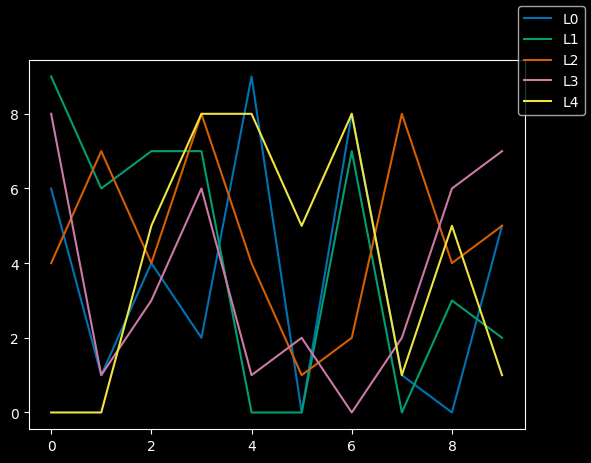

In [2]:
for style in plt.style.available:
    print(style)

plt.style.use("seaborn-colorblind")
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(np.arange(10), np.random.randint(0, 10, 10), label=f"L{i}")
fig.legend()

plt.style.use("seaborn-colorblind")

# trace hist

用于绘制 trace file 当中数据的分布情况

目前可以绘制数据的优先级统计图以及分布情况

## 目前只能绘制只有两个优先级的 trace file

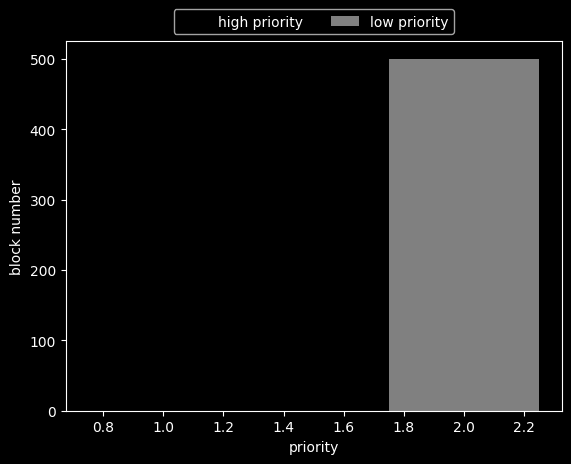

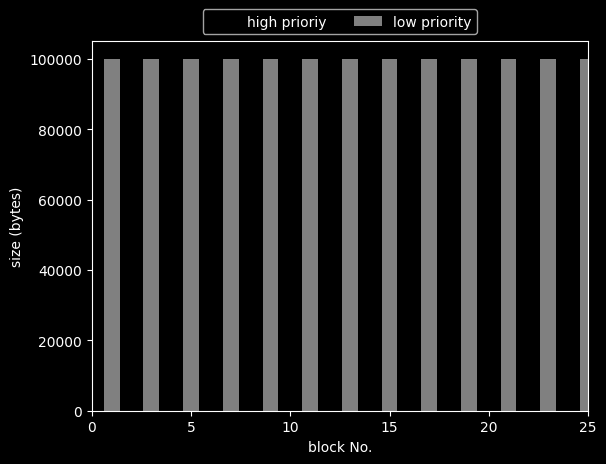

In [3]:
from xml.dom.pulldom import PROCESSING_INSTRUCTION


def trace_hist(trace_file_name, save=False, save_name=["distribute.svg", "data.svg"]):
    trace = parse_trace(trace_file_name)
    # print the distribution of block_size, ddl and priority with block num
    # print(
    #     trace.groupby("prio").agg(
    #         [
    #             pl.count(),
    #             pl.mean("size").alias("size_mean"),
    #             pl.var("size").alias("size_var"),
    #         ]
    #     )
    # )
    prio_trace = trace.partition_by("prio")
    prio_1 = prio_trace[0]["size"].to_numpy()
    prio_2 = prio_trace[1]["size"].to_numpy()

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")

    # block size trend with block num
    size_trace = trace["size"].to_numpy()
    fig, ax = plt.subplots()
    ax.bar([1], [len(prio_trace[0]["prio"])], color=["black"], width=0.5, label="high priority")
    ax.bar([2], [len(prio_trace[1]["prio"])], color=["grey"], width=0.5, label="low priority")
    ax.set_xlabel("priority")
    ax.set_ylabel("block number")
    ax.legend(ncol=2, bbox_to_anchor=(0.5, 1),
              loc='lower center')
    if save:
        fig.savefig(save_name[0])

    # distribution of trace
    fig, ax = plt.subplots()
    size = 28
    # ax.scatter(np.arange(len(trace[:size])), size_trace[:size], c=["orange" if trace[i]["prio"][0] == 1 else "blue" for i in range(len(size_trace[:size]))])
    xarray = []
    for i in range(size):
        if trace[i]["prio"][0] == 1:
            xarray.append(i)
    ax.bar(xarray, size_trace[:len(xarray)], color="black", label="high prioriy") 
    xarray = []
    for i in range(size):
        if trace[i]["prio"][0] == 2:
            xarray.append(i)
    ax.bar(xarray, size_trace[:len(xarray)], color="grey", label="low priority")
    ax.set_xlabel("block No.")
    ax.set_ylabel("size (bytes)")
    ax.set_xlim((0, 25))
    ax.legend(ncol=2, bbox_to_anchor=(0.5, 1),
              loc='lower center')
    if save:
        fig.savefig(save_name[1])
    # ax.plot(size_trace)
    # ax.scatter(prio_trace[0]["id"].to_numpy(), prio_trace[0]["size"].to_numpy(), c=["red"])
    # ax.scatter(prio_trace[1]["id"].to_numpy(), prio_trace[1]["size"].to_numpy(), c=["yellow"])
    # plt.savefig("trace_size.png")

    # result = pl.read_csv(result_file_name)
    # print(
    #     result.groupby("priority").agg(
    #         [
    #             pl.count(),
    #             pl.mean("bct").alias("bct_mean"),
    #             pl.var("bct").alias("bct_var"),
    #         ]
    #     )
    # )
    # result = result.partition_by("priority")
    # prio_1 = result[0]["bct"].to_numpy()
    # prio_2 = result[1]["bct"].to_numpy()
    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("bct (us)")
    # ax.set_ylabel("density")
    # plt.savefig("result_bct_hist.png")
trace_hist("data/trace_1300_1ms_1000_seq012.txt")

# get stats

利用 trace file 和一个客户端的输出来生成一些统计数据

In [4]:
def get_prio_groups(df, prio_col_name):
    '''
    Group trace rows by their priorities.

    Results are like: 

    [DataFrame(priority 1), Dataframe(priority2), ...]
    '''
    prio_list = df.partition_by(prio_col_name)
    # sort
    prio_list.sort(key=lambda x: x[prio_col_name][0])
    return prio_list
# good put and avg bct
def get_stats(result_file_path, trace_file_path):
    '''
    Print some basic stats like Throughput, block completion time (BCT) and block completion rate (BCR)
    '''
    print("===============================")
    print("stats of %s" % result_file_path)
    trace = parse_trace(trace_file_path)
    trace_prios = get_prio_groups(trace, "prio")
    trace_size = len(trace)

    all_bytes = np.sum(trace["size"].to_numpy())
    all_time = trace["start"][-1] + trace["ddl"][-1] * 1e-3
    ideal_throughput = all_bytes / all_time
    result = parse_result(result_file_path)
    in_time = result.filter(pl.col("bct") <= pl.col("deadline"))
    good_bytes = np.sum(in_time["size"].to_numpy())
    total_bytes = np.sum(result["size"].to_numpy())
    finish_time = result["duration"][-1] # micro
    throughput = total_bytes * 8 / finish_time # Mbps
    goodput = good_bytes * 8 / finish_time # Mbps
    avg_bct = np.average(result["bct"].to_numpy()) #ms
    avg_bcr = 0
    
    prio_result = get_prio_groups(result, "priority")

    for idx, prio_frame in enumerate(prio_result):
        print("------------")
        avg_prio_bct = np.average(prio_frame["bct"].to_numpy()) #ms
        print("prio", prio_frame["priority"][0], "avg_bct", avg_prio_bct)
        print("prio", prio_frame["priority"][0], "avg_bcr", len(prio_frame.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prios[idx]))
        avg_bcr += len(prio_frame.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prios[idx])
    avg_bcr /= len(trace_prios)
    print("-------------------------")
    print("ideal throughput: ", ideal_throughput, "Mbps")
    print("throughput:", throughput, "Mbps")
    print("goodput: ", goodput, "Mbps")
    print("avg_bcr(block completion rate):", avg_bcr)
    print("avg_bct(block completion time):", avg_bct)
# test
get_stats("data/client_n_n_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")

stats of data/client_n_n_fifo.csv
------------
prio 1 avg_bct 6272.96
prio 1 avg_bcr 0.322
------------
prio 2 avg_bct 6253.49
prio 2 avg_bcr 0.288
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 79.15136283311222 Mbps
goodput:  24.141165664099226 Mbps
avg_bcr(block completion rate): 0.305
avg_bct(block completion time): 6263.225


# get table stats

In [5]:
# good put and avg bct
def get_table_stats(result_file_paths, labels=[]):
    '''
    Print some basic stats like Throughput, block completion time (BCT) and block completion rate (BCR)
    in a table-like format

    Parameters:
    - result_file_paths: a list of result .csv file paths
    - labels: the label name of each result file, using result_file_path at default
    '''
    print("stats of %s" % str(result_file_paths))
    while len(labels) < len(result_file_paths):
        labels.append(result_file_paths[len(labels)])
    result_throughput = []
    result_goodput = []
    result_avg_bct = []
    result_prio1_bct = []
    result_prio2_bct = []
    for result_file_path in result_file_paths:
        result = parse_result(result_file_path)
        in_time = result.filter(pl.col("bct") <= pl.col("deadline"))
        good_bytes = np.sum(in_time["size"].to_numpy())
        total_bytes = np.sum(result["size"].to_numpy())
        finish_time = result["duration"][-1] # micro
        throughput = total_bytes * 8 / finish_time # Mbps
        goodput = good_bytes * 8 / finish_time # Mbps
        avg_bct = np.average(result["bct"].to_numpy()) #ms

        result_throughput.append(throughput)
        result_goodput.append(goodput)
        result_avg_bct.append(avg_bct)

        prio_result = result.partition_by("priority")
        for idx, prio_frame in enumerate(prio_result):
            avg_prio_bct = np.average(prio_frame["bct"].to_numpy()) #ms
            if prio_frame["priority"][0] == 1:
                result_prio1_bct.append(avg_prio_bct)
            elif prio_frame["priority"][0] == 2:
                result_prio2_bct.append(avg_prio_bct)
            else:
                print("priority %d is not expected" % (prio_frame["priority"][0]))
    print("|\t| %s |" % (" | ".join(labels)))
    print("| Throughput (Mbps) | %s |" % (" | ".join([x for x in map(lambda x: "%0.2f" % (x), result_throughput)])))
    print("| Goodput (Mbps) | %s |" % (" | ".join([x for x in map(lambda x: "%0.2f" % (x), result_goodput)])))
    print("| 平均块完成时间 (ms) | %s |" % (" | ".join([x for x in map(lambda x: "%d" % (int(x)), result_avg_bct)])))
    print("| 高优先级块平均完成时间 (ms) | %s |" % (" | ".join([x for x in map(lambda x: "%d" % (int(x)), result_prio1_bct)])))
    print("| 低优先级块平均完成时间 (ms) | %s |" % (" | ".join([x for x in map(lambda x: "%d" % (int(x)), result_prio2_bct)])))
# test
get_table_stats(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], labels=["QUIC", "DTP"])

stats of ['data/client_n_n_fifo.csv', 'data/client_n_n.csv']
|	| QUIC | DTP |
| Throughput (Mbps) | 79.15 | 37.23 |
| Goodput (Mbps) | 24.14 | 37.08 |
| 平均块完成时间 (ms) | 6263 | 3040 |
| 高优先级块平均完成时间 (ms) | 6272 | 2495 |
| 低优先级块平均完成时间 (ms) | 6253 | 4487 |


# draw figs

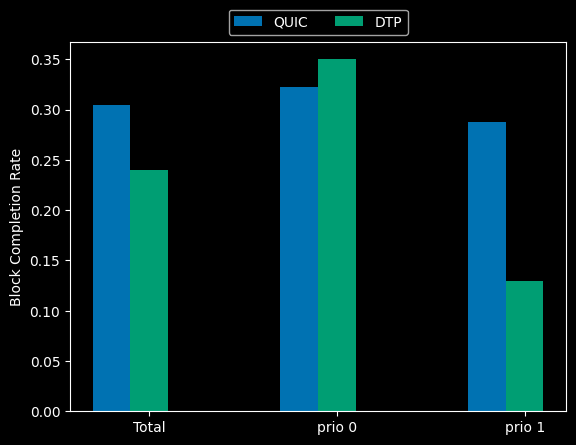

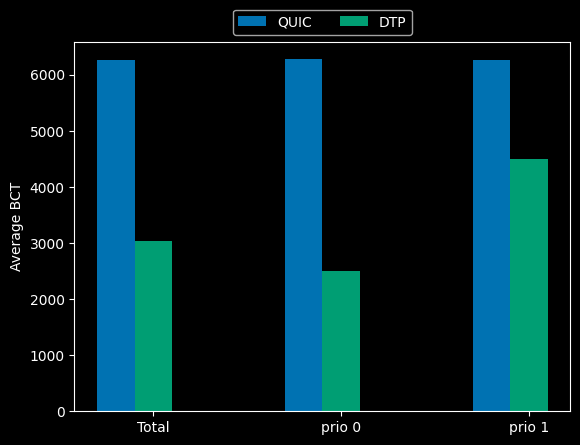

In [6]:
def draw_in_time_rate(result_file_path1, result_file_path2, trace_file_path, label1="QUIC", label2="DTP"):
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    result1_bcr = []
    result2_bcr = []
    for result_file_path in [result_file_path1, result_file_path2]:
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_file_path1 == result_file_path:
            result_bcr = result1_bcr
        else:
            result_bcr = result2_bcr
        # total_bcr = len(result.filter(pl.col("bct") <= pl.col("deadline"))) / trace_size
        prio1_bcr = len(result_prio1.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio1)
        prio2_bcr = len(result_prio2.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio2)
        # result_bcr.append(total_bcr)
        result_bcr.append(prio1_bcr)
        result_bcr.append(prio2_bcr)

    labels = ["High Priority", "Low Priority"]
    # quic_bcr = [len(results[0].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    # dtp_bcr = [len(results[1].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, result1_bcr, width, label=label1)
    rects2 = ax.bar(x + width/2, result2_bcr, width, label=label2)
    ax.set_ylabel('Block Completion Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

def draw_avg_bct(result_file_path1, result_file_path2, trace_file_path, label1="QUIC", label2="DTP"):
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    result1_bct = []
    result2_bct = []
    for result_file_path in [result_file_path1, result_file_path2]:
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_file_path1 == result_file_path:
            result_bcr = result1_bct
        else:
            result_bcr = result2_bct
        # total_bct = np.average(result["bct"].to_numpy())
        prio1_bct = np.average(result_prio1["bct"].to_numpy())
        prio2_bct = np.average(result_prio2["bct"].to_numpy())
        # result_bcr.append(total_bct)
        result_bcr.append(prio1_bct)
        result_bcr.append(prio2_bct)

    labels = ["High Priority", "Low Priority"]
    # quic_bcr = [len(results[0].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    # dtp_bcr = [len(results[1].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, result1_bct, width, label=label1)
    rects2 = ax.bar(x + width/2, result2_bct, width, label=label2)
    ax.set_ylabel('Average BCT')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

def draw_cmp_fig(result_file_paths, trace_file_path, labels=[], width=0.2, with_total=True, save=False, save_name=["bcr.svg", "bct.svg"], ylabel=["Block Completion Rate", "Average BCT"]):
    '''
    Draw comparision figures of given result files of BCR and average BCT

    Parameters:
    - result_file_paths(list of str): a list of result .csv file paths
    - trace_file_path(str): the path of trace file
    - labels(list): the xlabel name of each result file, using result_file_path at default
    - width(float): the width of hist
    - with_total(bool): traw the figure with the Total statistic hist
    - save(bool): save the figure with the given path of save_name
    - save_name(list of str): two paths of to save the figures
    - ylabel: the ylabel of each figure
    '''
    if not trace_file_path:
        print("no trace file path")
        return
    while len(labels) < len(result_file_paths):
        labels.append(result_file_paths[len(labels)])
    trace = parse_trace(trace_file_path)
    trace_prios = get_prio_groups(trace, "prio")
    trace_size = len(trace)
    bcrs = [[] for r in result_file_paths]
    bcts = [[] for r in result_file_paths]

    for idx, result_file_path in enumerate(result_file_paths):
        result = parse_result(result_file_path)
        result_prios = get_prio_groups(result, "priority")
        
        result_bcr = bcrs[idx]
        total_bcr = len(result.filter(pl.col("bct") <= pl.col("deadline"))) / trace_size
        if with_total:
            result_bcr.append(total_bcr)

        for i, result_prio in enumerate(result_prios):
            prio_bcr = len(result_prio.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prios[i])
            result_bcr.append(prio_bcr)

        result_bct = bcts[idx]
        total_bct = np.average(result["bct"].to_numpy())
        if with_total:
            result_bct.append(total_bct)

        for i, result_prio in enumerate(result_prios):
            prio_bct = np.average(result_prio["bct"].to_numpy())
            result_bct.append(prio_bct)
    
    # if with_total:
    #     x_labels = ["Total", "High Priority", "Low Priority"]
    # else:
    #     x_labels = ["High Priority", "Low Priority"]
    if with_total:
        x_labels = ["Total"]
    else:
        x_labels = []

    for i in range(len(trace_prios)):
        x_labels.append("prio %d" % i)

    x = np.arange(len(x_labels))  # the label locations
    fig, ax = plt.subplots()
    for idx, bcr in enumerate(bcrs):
        ax.bar(x + width * (idx - len(bcrs) // 2), bcr, width, label=labels[idx])
    ax.set_ylabel(ylabel[0])
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend(ncol=len(x_labels) + 1, bbox_to_anchor=(0.5, 1),
              loc='lower center')
    if save:
        fig.savefig(save_name[0])

    x = np.arange(len(x_labels))  # the label locations
    fig, ax = plt.subplots()
    for idx, bct in enumerate(bcts):
        ax.bar(x + width * (idx - len(bcts) // 2), bct, width, label=labels[idx])
    ax.set_ylabel(ylabel[1])
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    # ax.legend()
    ax.legend(ncol=len(x_labels) + 1, bbox_to_anchor=(0.5, 1),
              loc='lower center')
    if save:
        fig.savefig(save_name[1])
# test        
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

# original data1

## trace hist

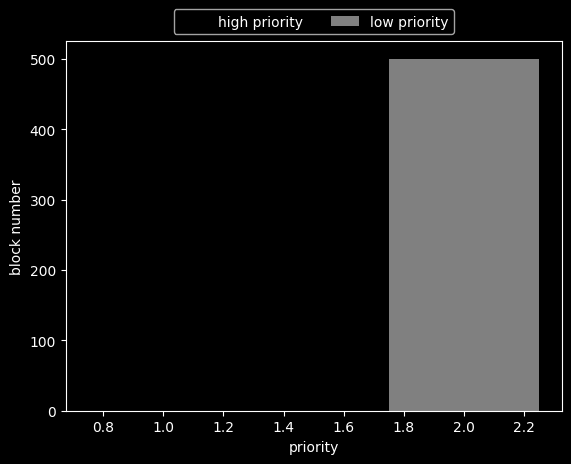

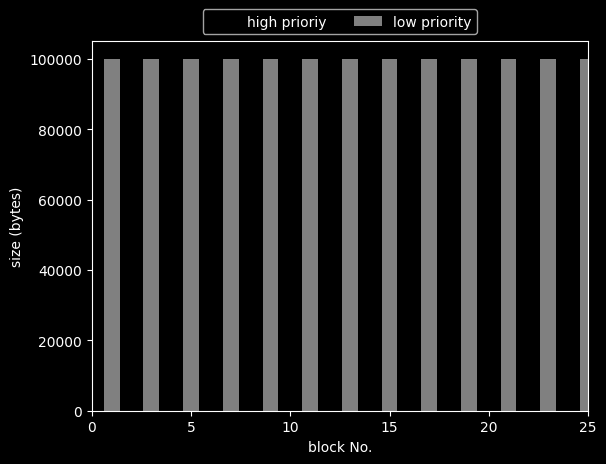

In [7]:
trace_hist("data/trace_1300_1ms_1000_seq012.txt")

## fifo on/off

stats of data/client_n_n_fifo.csv
------------
prio 1 avg_bct 6272.96
prio 1 avg_bcr 0.322
------------
prio 2 avg_bct 6253.49
prio 2 avg_bcr 0.288
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 79.15136283311222 Mbps
goodput:  24.141165664099226 Mbps
avg_bcr(block completion rate): 0.305
avg_bct(block completion time): 6263.225
stats of data/client_n_n.csv
------------
prio 1 avg_bct 2495.497142857143
prio 1 avg_bcr 0.35
------------
prio 2 avg_bct 4487.272727272727
prio 2 avg_bcr 0.13
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 37.23159170075378 Mbps
goodput:  37.07710376838551 Mbps
avg_bcr(block completion rate): 0.24
avg_bct(block completion time): 3040.9626556016597


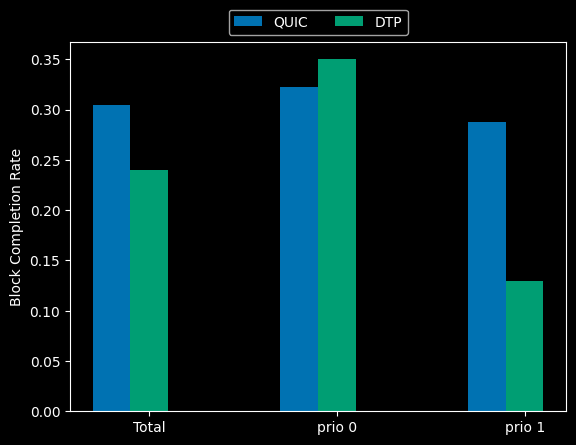

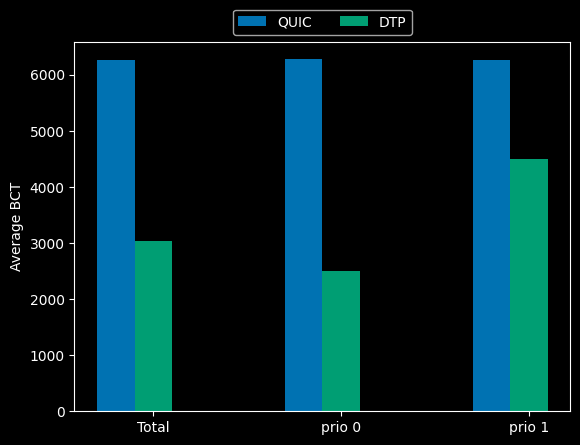

In [8]:
get_stats("data/client_n_n_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")
get_stats("data/client_n_n.csv",  "data/trace_1300_1ms_1000_seq012.txt")
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

## tos on/off

stats of data/client_t_n_fifo.csv
------------
prio 1 avg_bct 6654.048
prio 1 avg_bcr 0.312
------------
prio 2 avg_bct 6785.242
prio 2 avg_bcr 0.272
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 70.32124414454778 Mbps
goodput:  20.533803290207953 Mbps
avg_bcr(block completion rate): 0.29200000000000004
avg_bct(block completion time): 6719.645
stats of data/client_t_t_fifo.csv
------------
prio 1 avg_bct 3468.5
prio 1 avg_bcr 0.818
------------
prio 2 avg_bct 3425.816
prio 2 avg_bcr 0.818
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 125.96663647666279 Mbps
goodput:  103.04070863791016 Mbps
avg_bcr(block completion rate): 0.818
avg_bct(block completion time): 3447.158


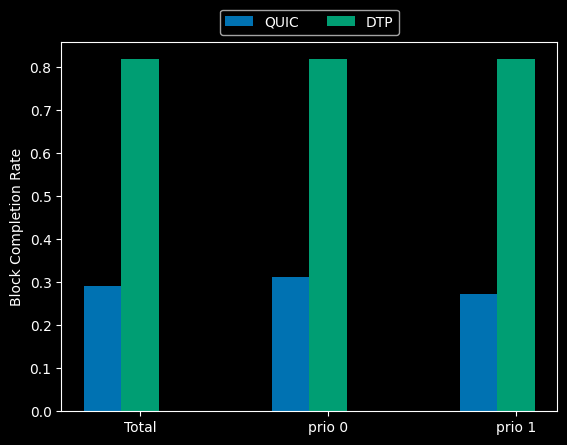

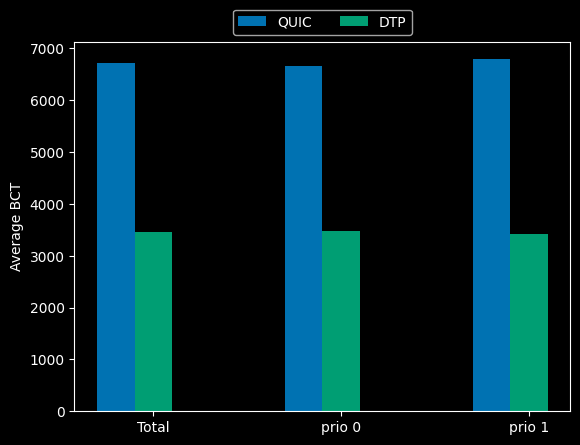

In [9]:
get_stats("data/client_t_n_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")
get_stats("data/client_t_t_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")
draw_cmp_fig(["data/client_t_n_fifo.csv", "data/client_t_t_fifo.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

# data display

## original data all

In [10]:
get_stats("data/client_n_n_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")
get_stats("data/client_n_n.csv", "data/trace_1300_1ms_1000_seq012.txt")
get_stats("data/client_t_t_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")
get_stats("data/client_t_t.csv", "data/trace_1300_1ms_1000_seq012.txt")

stats of data/client_n_n_fifo.csv
------------
prio 1 avg_bct 6272.96
prio 1 avg_bcr 0.322
------------
prio 2 avg_bct 6253.49
prio 2 avg_bcr 0.288
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 79.15136283311222 Mbps
goodput:  24.141165664099226 Mbps
avg_bcr(block completion rate): 0.305
avg_bct(block completion time): 6263.225
stats of data/client_n_n.csv
------------
prio 1 avg_bct 2495.497142857143
prio 1 avg_bcr 0.35
------------
prio 2 avg_bct 4487.272727272727
prio 2 avg_bcr 0.13
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 37.23159170075378 Mbps
goodput:  37.07710376838551 Mbps
avg_bcr(block completion rate): 0.24
avg_bct(block completion time): 3040.9626556016597
stats of data/client_t_t_fifo.csv
------------
prio 1 avg_bct 3468.5
prio 1 avg_bcr 0.818
------------
prio 2 avg_bct 3425.816
prio 2 avg_bcr 0.818
-------------------------
ideal throughput:  16666666.666666664 Mbps
throughput: 125.96663647666279 M

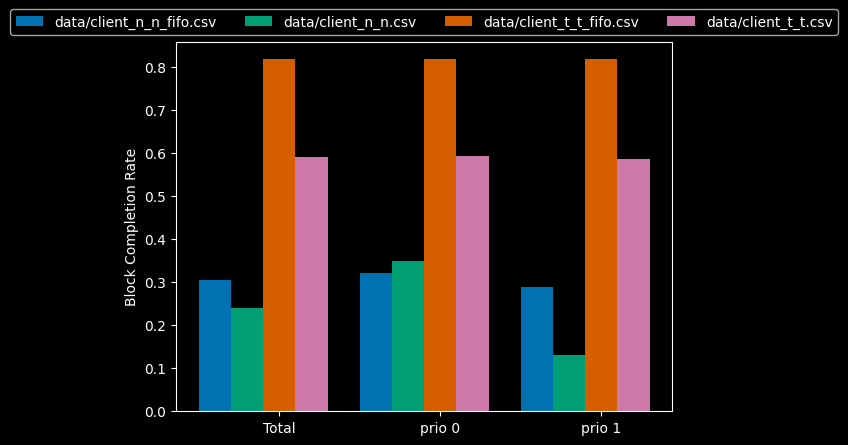

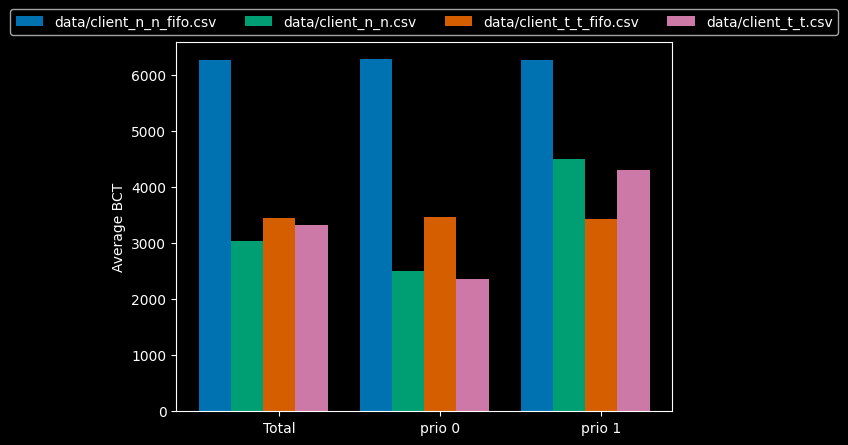

In [11]:
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv", "data/client_t_t_fifo.csv", "data/client_t_t.csv"], "data/trace_1300_1ms_1000_seq012.txt")

## 25 data 100000 1

stats of 25data/client_25_100000_1_n_n.csv
------------
prio 1 avg_bct 38951.829
prio 1 avg_bcr 0.029
------------
prio 2 avg_bct 38162.348
prio 2 avg_bcr 0.039
-------------------------
ideal throughput:  37500000.00000103 Mbps
throughput: 30.29509046473767 Mbps
goodput:  1.0805248932423102 Mbps
avg_bcr(block completion rate): 0.034
avg_bct(block completion time): 38425.50833333333
stats of 25data/client_25_100000_1_n_t.csv
------------
prio 1 avg_bct 6436.2402234636875
prio 1 avg_bcr 0.133
------------
prio 2 avg_bct 6711.848441926346
prio 2 avg_bcr 0.12
-------------------------
ideal throughput:  37500000.00000103 Mbps
throughput: 51.024127122968146 Mbps
goodput:  17.887217497055563 Mbps
avg_bcr(block completion rate): 0.1265
avg_bct(block completion time): 6619.1156015037595
stats of 25data/client_25_100000_1_t_n.csv
------------
prio 1 avg_bct 4422.523809523809
prio 1 avg_bcr 0.088
------------
prio 2 avg_bct 4502.261261261261
prio 2 avg_bcr 0.029
-------------------------
ideal 

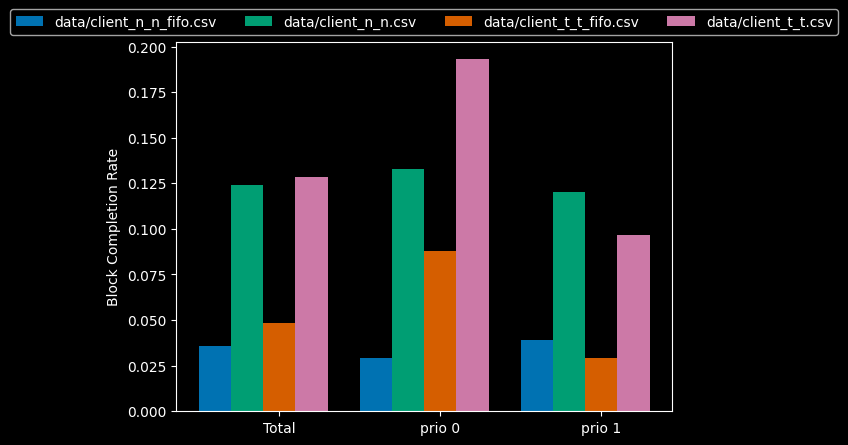

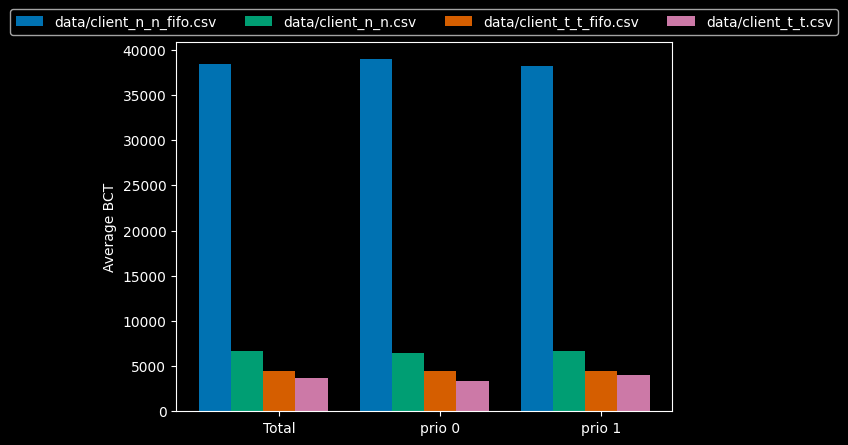

In [12]:
n_n_file = "25data/client_25_100000_1_n_n.csv"
n_t_file = "25data/client_25_100000_1_n_t.csv" 
t_n_file = "25data/client_25_100000_1_t_n.csv" 
t_t_file = "25data/client_25_100000_1_t_t.csv" 
trace_file = "trace_tos_2.txt" 
get_stats(n_n_file, trace_file)
get_stats(n_t_file, trace_file)
get_stats(t_n_file, trace_file)
get_stats(t_t_file, trace_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], trace_file)

## 25 data 10000 1

stats of 25data/client_25_10000_1_n_n.csv
------------
prio 1 avg_bct 1891.851
prio 1 avg_bcr 0.923
------------
prio 2 avg_bct 1826.19
prio 2 avg_bcr 0.927
-------------------------
ideal throughput:  3750000.000000103 Mbps
throughput: 32.137045215617476 Mbps
goodput:  29.74819152125658 Mbps
avg_bcr(block completion rate): 0.925
avg_bct(block completion time): 1848.077
stats of 25data/client_25_10000_1_n_t.csv
------------
prio 1 avg_bct 1936.48
prio 1 avg_bcr 0.925
------------
prio 2 avg_bct 1963.763
prio 2 avg_bcr 0.9195
-------------------------
ideal throughput:  3750000.000000103 Mbps
throughput: 32.99986057558907 Mbps
goodput:  30.40387154364273 Mbps
avg_bcr(block completion rate): 0.92225
avg_bct(block completion time): 1954.6686666666667
stats of 25data/client_25_10000_1_t_n.csv
------------
prio 1 avg_bct 1045.301
prio 1 avg_bcr 1.0
------------
prio 2 avg_bct 2192.016
prio 2 avg_bcr 1.0
-------------------------
ideal throughput:  3750000.000000103 Mbps
throughput: 32.42925

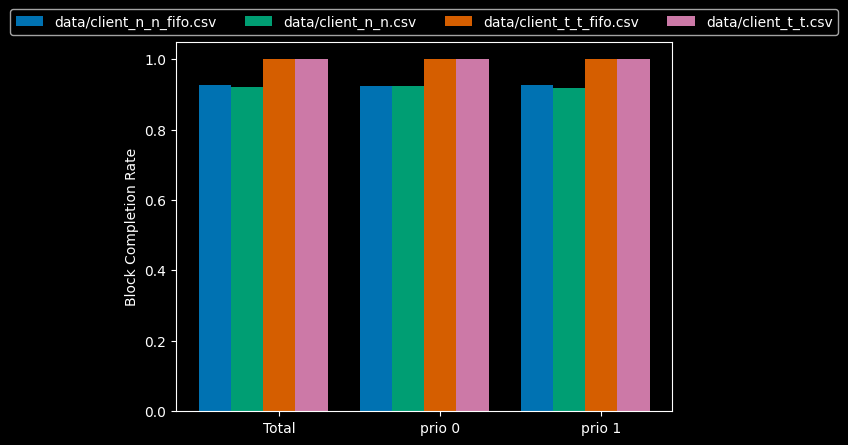

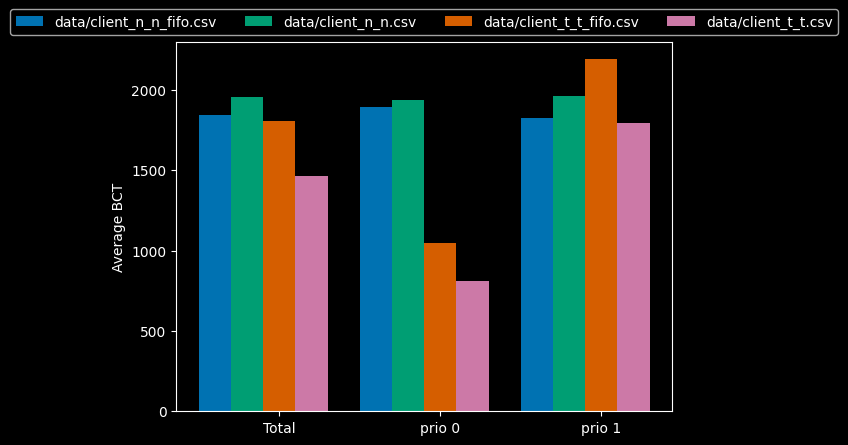

In [13]:
n_n_file = "25data/client_25_10000_1_n_n.csv"
n_t_file = "25data/client_25_10000_1_n_t.csv" 
t_n_file = "25data/client_25_10000_1_t_n.csv" 
t_t_file = "25data/client_25_10000_1_t_t.csv" 
trace_file = "trace_tos_1.txt"
get_stats(n_n_file, trace_file)
get_stats(n_t_file, trace_file)
get_stats(t_n_file, trace_file)
get_stats(t_t_file, trace_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], trace_file)

## 25 data 30000 1

stats of 25data/client_25_30000_1_n_n.csv
------------
prio 1 avg_bct 10333.634
prio 1 avg_bcr 0.2
------------
prio 2 avg_bct 10676.9095
prio 2 avg_bcr 0.1765
-------------------------
ideal throughput:  11250000.00000031 Mbps
throughput: 28.793262376603874 Mbps
goodput:  5.307558031420648 Mbps
avg_bcr(block completion rate): 0.18825
avg_bct(block completion time): 10562.484333333334
stats of 25data/client_25_30000_1_n_t.csv
------------
prio 1 avg_bct 2620.65
prio 1 avg_bcr 0.355
------------
prio 2 avg_bct 2685.5837912087914
prio 2 avg_bcr 0.359
-------------------------
ideal throughput:  11250000.00000031 Mbps
throughput: 41.162506618837114 Mbps
goodput:  40.595008825378876 Mbps
avg_bcr(block completion rate): 0.357
avg_bct(block completion time): 2664.098345588235
stats of 25data/client_25_30000_1_t_n.csv
------------
prio 1 avg_bct 4163.215568862275
prio 1 avg_bcr 0.379
------------
prio 2 avg_bct 4857.480456026059
prio 2 avg_bcr 0.1975
-------------------------
ideal throughput

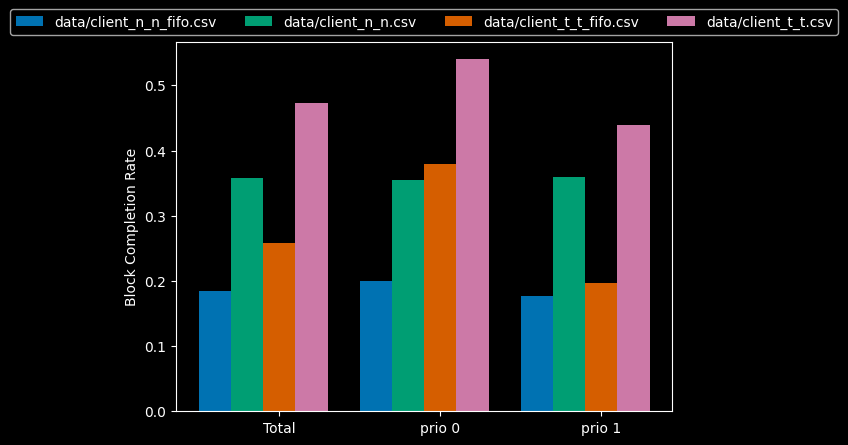

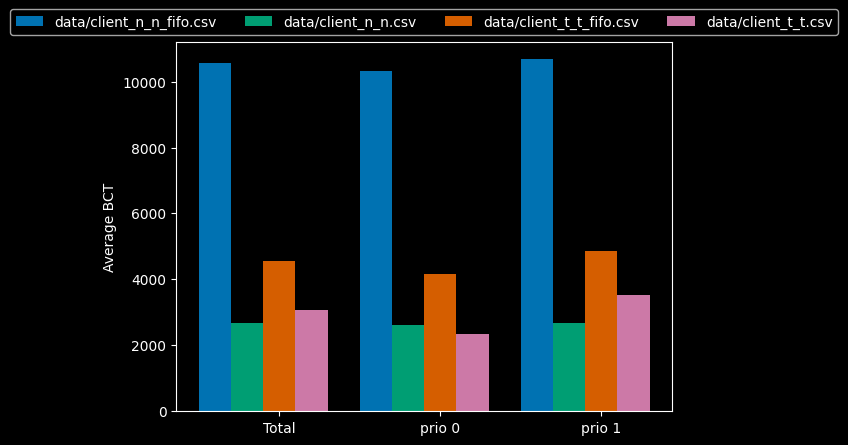

In [14]:
n_n_file = "25data/client_25_30000_1_n_n.csv"
n_t_file = "25data/client_25_30000_1_n_t.csv" 
t_n_file = "25data/client_25_30000_1_t_n.csv" 
t_t_file = "25data/client_25_30000_1_t_t.csv" 
trace_file = "trace_tos_3.txt"
get_stats(n_n_file, trace_file)
get_stats(n_t_file, trace_file)
get_stats(t_n_file, trace_file)
get_stats(t_t_file, trace_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], trace_file)

#  Paper result 30000

In [15]:
n_n_file = "25data/client_25_30000_1_n_n.csv"
n_t_file = "25data/client_25_30000_1_n_t.csv" 
t_n_file = "25data/client_25_30000_1_t_n.csv" 
t_t_file = "25data/client_25_30000_1_t_t.csv" 
trace_file = "trace_tos_3.txt"

## trace hist

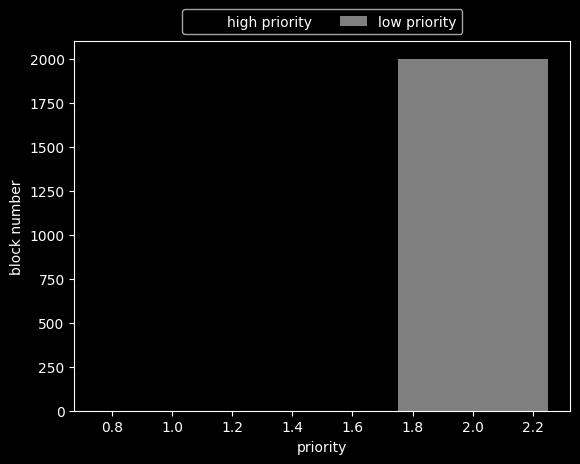

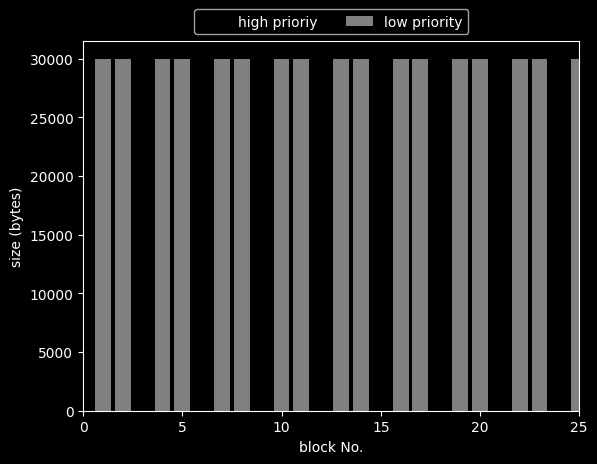

In [16]:
trace_hist(trace_file, save=True, save_name=["new_imgs/trace.svg", "new_imgs/trace_distribute.svg"])

## fifo on/off

stats of ['25data/client_25_30000_1_n_n.csv', '25data/client_25_30000_1_t_n.csv']
|	| QUIC | DTP |
| Throughput (Mbps) | 28.79 | 24.06 |
| Goodput (Mbps) | 5.31 | 16.70 |
| 平均块完成时间 (ms) | 10562 | 4545 |
| 高优先级块平均完成时间 (ms) | 10333 | 4163 |
| 低优先级块平均完成时间 (ms) | 10676 | 4857 |


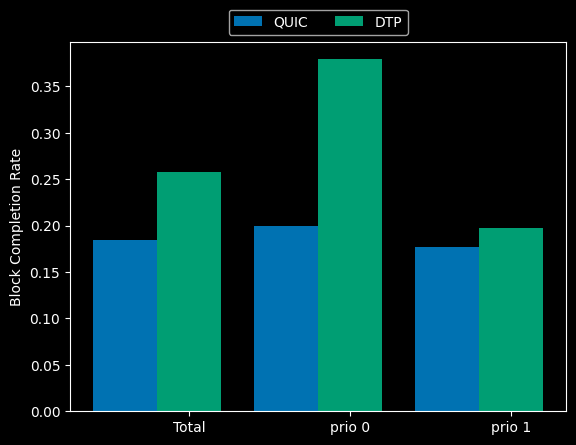

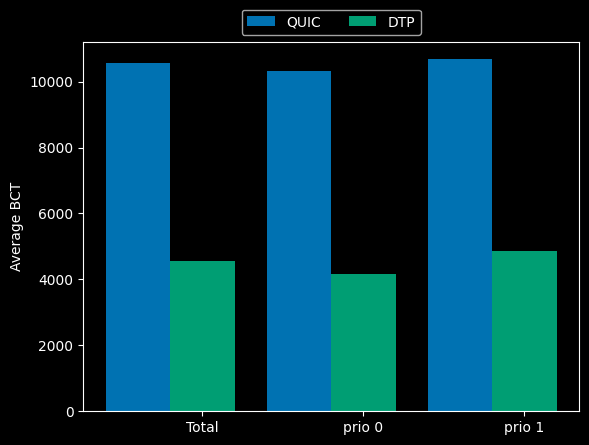

In [17]:
get_table_stats([n_n_file, t_n_file], labels=["QUIC", "DTP"])
draw_cmp_fig([n_n_file, t_n_file], trace_file, ["QUIC", "DTP"], width=0.4, save=True, save_name=["new_imgs/bcr.svg", "new_imgs/bct.svg"])

## tos on/off

stats of ['25data/client_25_30000_1_n_n.csv', '25data/client_25_30000_1_n_t.csv']
|	| NO DS | DS |
| Throughput (Mbps) | 28.79 | 41.16 |
| Goodput (Mbps) | 5.31 | 40.60 |
| 平均块完成时间 (ms) | 10562 | 2664 |
| 高优先级块平均完成时间 (ms) | 10333 | 2620 |
| 低优先级块平均完成时间 (ms) | 10676 | 2685 |


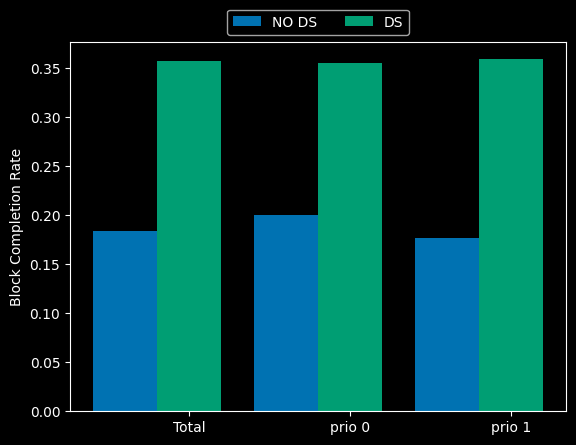

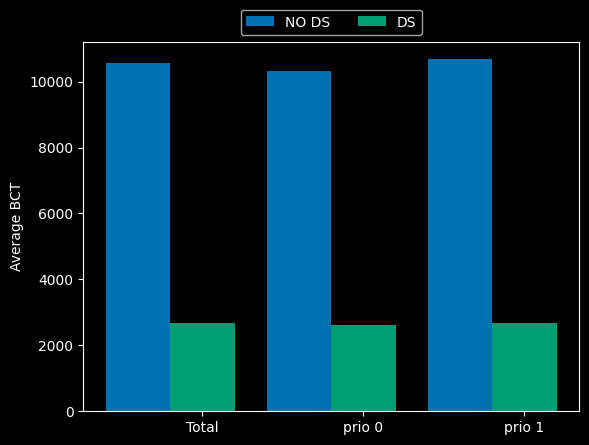

In [18]:
get_table_stats([n_n_file, n_t_file], labels=["NO DS", "DS"])
draw_cmp_fig([n_n_file, n_t_file], trace_file, ["NO DS", "DS"], width=0.4, save=True, save_name=["new_imgs/ds_bcr.svg", "new_imgs/ds_bct.svg"])

## final stats

stats of 25data/client_25_30000_1_n_n.csv
------------
prio 1 avg_bct 10333.634
prio 1 avg_bcr 0.2
------------
prio 2 avg_bct 10676.9095
prio 2 avg_bcr 0.1765
-------------------------
ideal throughput:  11250000.00000031 Mbps
throughput: 28.793262376603874 Mbps
goodput:  5.307558031420648 Mbps
avg_bcr(block completion rate): 0.18825
avg_bct(block completion time): 10562.484333333334

stats of 25data/client_25_30000_1_n_t.csv
------------
prio 1 avg_bct 2620.65
prio 1 avg_bcr 0.355
------------
prio 2 avg_bct 2685.5837912087914
prio 2 avg_bcr 0.359
-------------------------
ideal throughput:  11250000.00000031 Mbps
throughput: 41.162506618837114 Mbps
goodput:  40.595008825378876 Mbps
avg_bcr(block completion rate): 0.357
avg_bct(block completion time): 2664.098345588235

stats of 25data/client_25_30000_1_t_n.csv
------------
prio 1 avg_bct 4163.215568862275
prio 1 avg_bcr 0.379
------------
prio 2 avg_bct 4857.480456026059
prio 2 avg_bcr 0.1975
-------------------------
ideal throughp

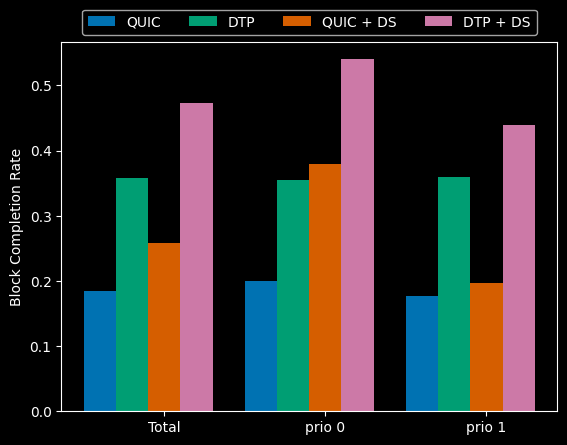

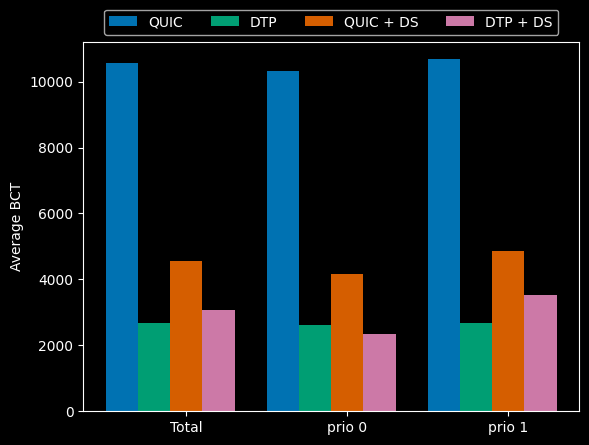

In [19]:
get_stats(n_n_file, trace_file)
print()
get_stats(n_t_file, trace_file)
print()
get_stats(t_n_file, trace_file)
print()
get_stats(t_t_file, trace_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], trace_file, labels=["QUIC", "DTP", "QUIC + DS", "DTP + DS"], width=0.2, save=True, save_name=["new_imgs/total_bcr.svg", "new_imgs/total_bct.svg"])

# Playground

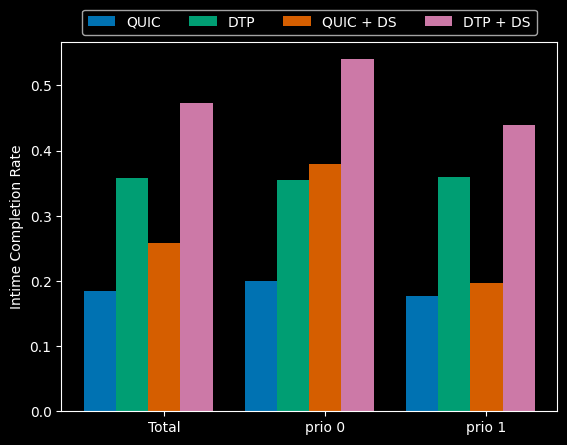

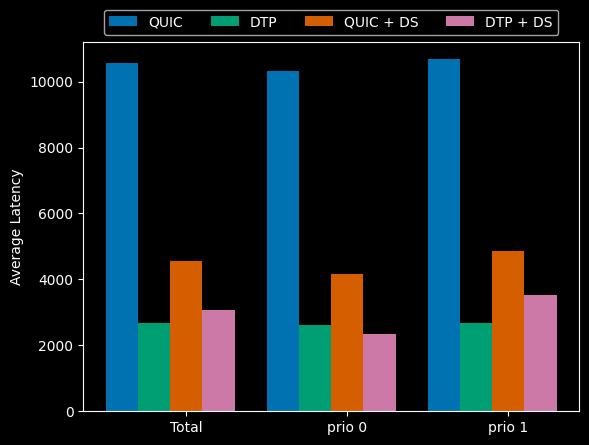

In [20]:
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], trace_file, labels=["QUIC", "DTP", "QUIC + DS", "DTP + DS"], width=0.2, save=True, save_name=["1.svg", "2.svg"], ylabel=['Intime Completion Rate', 'Average Latency'])